# Presentación

## Introducción

**TUIA - Aprendizaje Automático 1** - 2023

---

**Trabajo Práctico Integrador** - "Predicción de lluvia en Australia"

**Alumnos:**  

*   Brisa Menescaldi
*   Miguel Mussi



## Objetivo


Familiarizarse con la librería scikit-learn y las herramientas que brinda para el pre-procesamiento de datos, la implementación de modelos y la evaluación de métricas, y con TensorFlow para el entrenamiento de redes neuronales.

## Dataset



El dataset se llama weatherAUS.csv y contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las columnas ‘RainTomorrow’ y ‘RainfallTomorrow’. El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas.

Tiene una columna ‘Location’ que indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

## Consignas





1. Armar grupos de hasta dos personas para la realización del trabajo práctico. Dar aviso al cuerpo docente del equipo. En caso de no tener compañero, informar al cuerpo docente.


2. Realizar un análisis descriptivo, que ayude a la comprensión del problema, de cada una de las variables involucradas en el problema detallando características, comportamiento y rango de variación.
Debe incluir:

> * Análisis y decisión sobre datos faltantes
* Visualización de datos (por ejemplo histogramas, scatterplots entre variables, diagramas de caja)
* ¿Está balanceado el dataset?
* Codificación de variables categóricas (si se van a utilizar para predicción).
* Matriz de correlación
* Selección de características para la predicción.
* Estandarización de datos.


3. Implementar la solución del problema de regresión con regresión lineal múltiple.

> * Probar con el método LinearRegression.
* Probar con métodos de gradiente descendiente.
* Probar con métodos de regularización (Lasso, Ridge, Elasticnet).
* Obtener las métricas adecuadas (entre R2 Score, MSE, RMSE, MAE, MAPE).


4. Implementar la solución del problema de clasificación con regresión logística.

> * Obtener las métricas adecuadas (entre Accuracy, precision, recall, F1 Score, ROC-AUC, entre otras).


5. Implementar las soluciones con una red neuronal.

> * Obtener las métricas adecuadas.


6. Mejorar la selección de hiperparámetros.

> * Probar validación cruzada.


7. MLOps (a definir).


8. Escribir una conclusión del trabajo

# Desarrollo

## Análisis descriptivo

In [7]:
#@title Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [8]:
#@title Sincronización con Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#@title DataFrame

# Path referenciado a la carpeta de Drive
#file_path= '/content/drive/MyDrive/UNR/4 - Aprendizaje Automático (IA41)/Trabajo Práctico/weatherAUS.csv'
#file_path= '/content/weatherAUS.csv'
#df = pd.read_csv(file_path, sep=',', engine='python')

df = pd.read_csv('weatherAUS.csv', sep=',', engine='python')

In [10]:
df

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18606,18611,2010-05-12,NorahHead,10.9,17.3,0.0,NaN,NaN,S,44.0,...,50.0,1017.7,1016.7,NaN,NaN,13.7,17.0,No,No,0.0
18607,18612,2010-05-13,NorahHead,8.8,19.4,0.0,NaN,NaN,S,31.0,...,50.0,1018.7,1015.7,NaN,NaN,14.4,19.2,No,No,0.0
18608,18613,2010-05-14,NorahHead,11.0,18.9,0.0,NaN,NaN,S,41.0,...,48.0,1017.9,1014.8,NaN,NaN,15.3,18.7,No,No,0.0
18609,18614,2010-05-15,NorahHead,12.2,19.9,0.0,NaN,NaN,S,41.0,...,65.0,1017.1,1015.8,NaN,NaN,15.8,19.4,No,No,0.0


In [11]:
df = df.drop(['Unnamed: 0'], axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18611 entries, 0 to 18610
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              18611 non-null  object 
 1   Location          18611 non-null  object 
 2   MinTemp           18183 non-null  float64
 3   MaxTemp           18304 non-null  float64
 4   Rainfall          18159 non-null  float64
 5   Evaporation       6743 non-null   float64
 6   Sunshine          4099 non-null   float64
 7   WindGustDir       14958 non-null  object 
 8   WindGustSpeed     14959 non-null  float64
 9   WindDir9am        15718 non-null  object 
 10  WindDir3pm        16764 non-null  object 
 11  WindSpeed9am      17918 non-null  float64
 12  WindSpeed3pm      17233 non-null  float64
 13  Humidity9am       18140 non-null  float64
 14  Humidity3pm       17441 non-null  float64
 15  Pressure9am       15037 non-null  float64
 16  Pressure3pm       15037 non-null  float6

In [13]:
df.isna().sum()

Date                    0
Location                0
MinTemp               428
MaxTemp               307
Rainfall              452
Evaporation         11868
Sunshine            14512
WindGustDir          3653
WindGustSpeed        3652
WindDir9am           2893
WindDir3pm           1847
WindSpeed9am          693
WindSpeed3pm         1378
Humidity9am           471
Humidity3pm          1170
Pressure9am          3574
Pressure3pm          3574
Cloud9am             7232
Cloud3pm             7544
Temp9am               328
Temp3pm              1021
RainToday             452
RainTomorrow          452
RainfallTomorrow      452
dtype: int64

In [14]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,18183.000000,18304.000000,18159.00000,6743.000000,4099.000000,14959.000000,17918.000000,17233.000000,18140.000000,17441.000000,15037.000000,15037.000000,11379.000000,11067.000000,18283.000000,17590.000000,18159.000000
mean,12.568993,24.568187,2.51700,6.292288,8.307124,36.660338,11.845686,15.741833,68.381092,48.222751,1018.245062,1015.480654,4.066614,4.302521,17.741853,23.127112,2.516978
std,6.171405,6.583798,9.82783,5.491290,3.754820,12.618878,8.774320,8.801623,18.653550,21.109581,6.585564,6.490481,3.064427,2.778613,5.825036,6.432615,9.827835
min,-3.300000,6.800000,0.00000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,989.800000,982.900000,0.000000,0.000000,0.300000,6.400000,0.000000
25%,7.700000,19.600000,0.00000,2.800000,6.200000,28.000000,6.000000,9.000000,56.000000,32.000000,1013.700000,1011.000000,1.000000,1.000000,13.500000,18.200000,0.000000
50%,12.900000,24.200000,0.00000,5.000000,9.600000,35.000000,11.000000,15.000000,69.000000,47.000000,1018.300000,1015.500000,4.000000,5.000000,18.200000,22.600000,0.000000
75%,17.600000,29.000000,0.40000,8.200000,11.000000,44.000000,17.000000,20.000000,82.000000,63.000000,1022.700000,1019.900000,7.000000,7.000000,22.100000,27.400000,0.400000
max,29.700000,47.300000,371.00000,86.200000,14.000000,117.000000,130.000000,83.000000,100.000000,100.000000,1039.900000,1036.800000,8.000000,8.000000,37.700000,46.700000,371.000000


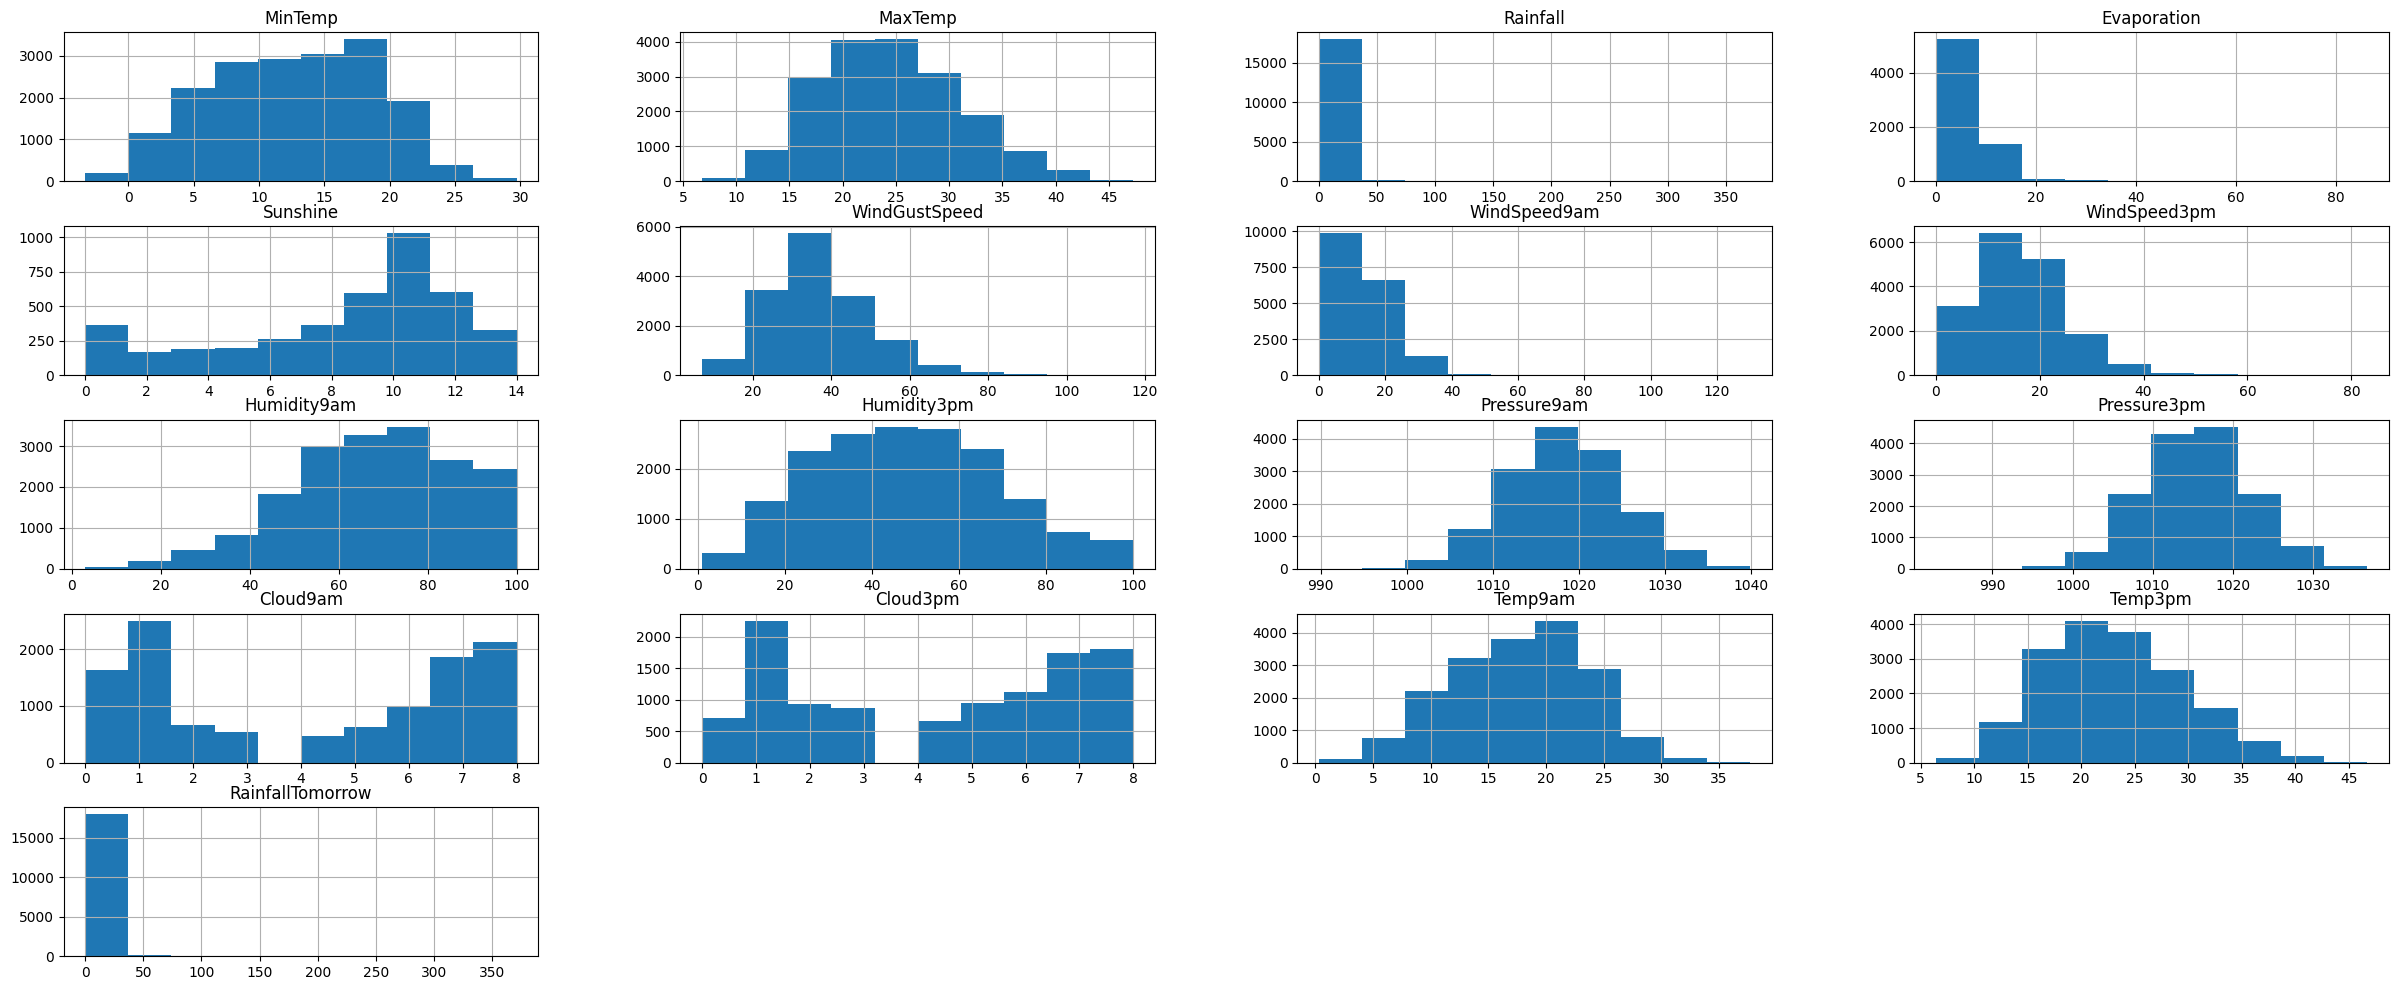

In [15]:
df.hist(figsize=(30,12))
plt.show()

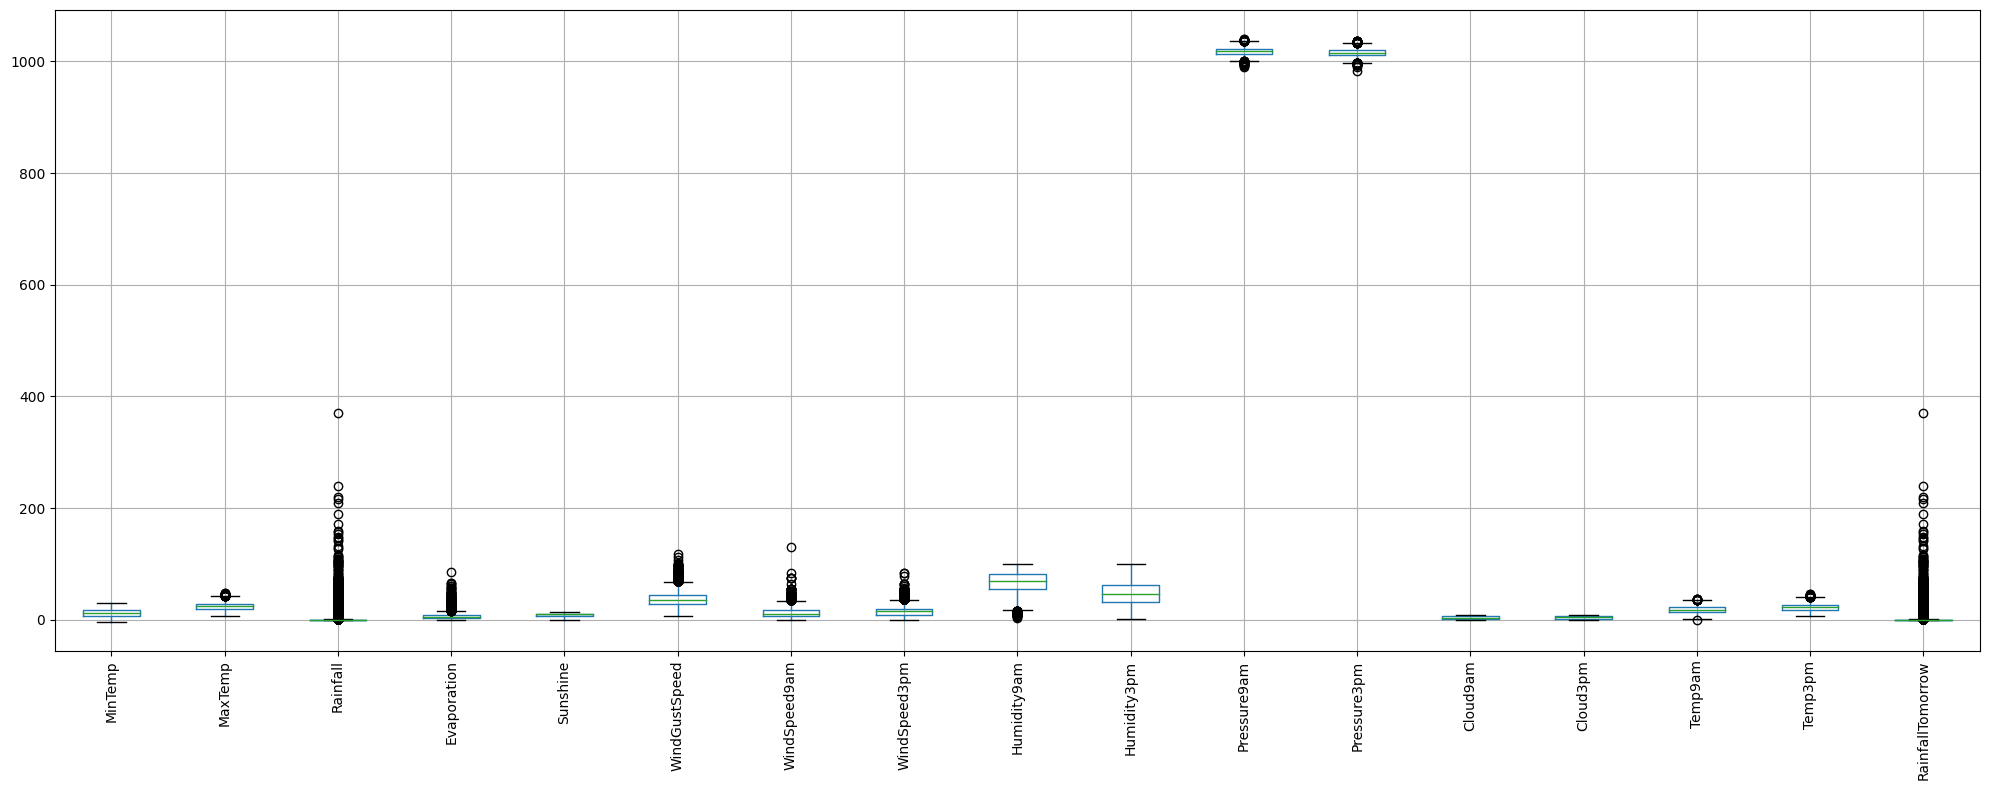

In [16]:
plt.figure(figsize=(20, 8))
df.boxplot(rot=90)
plt.tight_layout()  #para que las etiquetas no se superpongan
plt.show()

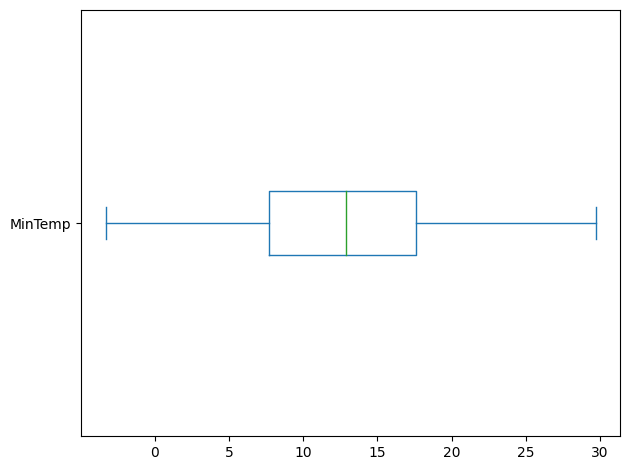

In [17]:
# Para ver de más cerca las columnas con menos rango
df['MinTemp'].plot(kind='box', vert=False)
plt.tight_layout()
plt.show()

# Limpieza del Dataset

In [18]:
df['Location'] = df['Location'].astype('category')

In [19]:
# Agrupar por etiqueta y contar la frecuencia
Location_frec = df['Location'].value_counts()
Location_frec

Albury           3039
Newcastle        3039
BadgerysCreek    3008
Cobar            3008
CoffsHarbour     3008
Moree            3008
NorahHead         500
NorahH              1
Name: Location, dtype: int64

Se desea analizar únicamente los registros correspondientes a las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

In [20]:
ciudades_a_conservar = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df_filtrado = df[df['Location'].isin(ciudades_a_conservar)]

# Eliminar las filas que tienen valores nulos en la columna 'Location'
df_filtrado = df_filtrado.dropna(subset=['Location'])
df_filtrado

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow


Se reemplaza valores nulos por las medias de cada columna que los contiene

In [21]:
df_filtrado['WindGustSpeed'].fillna(value=df_filtrado['WindGustSpeed'].mean(), inplace=True)
df_filtrado['WindGustSpeed'].fillna(value=df_filtrado['WindGustSpeed'].mean(), inplace=True)
df_filtrado['WindGustSpeed'].fillna(value=df_filtrado['WindGustSpeed'].mean(), inplace=True)
df_filtrado['WindGustSpeed'].fillna(value=df_filtrado['WindGustSpeed'].mean(), inplace=True)
df_filtrado['WindGustSpeed'].fillna(value=df_filtrado['WindGustSpeed'].mean(), inplace=True)
df_filtrado['WindGustSpeed'].fillna(value=df_filtrado['WindGustSpeed'].mean(), inplace=True)

Eliminación de registros que contengan valores nulos en columnas específicas

Comprobación de filtrado

In [22]:
# Agrupar por etiqueta y contar la frecuencia
Loc_frec = df_filtrado['Location'].value_counts()
Loc_frec

Albury           0
BadgerysCreek    0
Cobar            0
CoffsHarbour     0
Moree            0
Newcastle        0
NorahH           0
NorahHead        0
Name: Location, dtype: int64

Codificación de variables categóricas (RainToday y RainTomorrow), dónde 'Yes' = 1 y 'No' = 0.
Primero eliminamos las filas dónde para dichas columnas su valor es Nan.


In [28]:
df_filtrado.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
df_filtrado['RainToday'] = df_filtrado['RainToday'].replace('Yes',1)
df_filtrado['RainToday'] = df_filtrado['RainToday'].replace('No',0)
df_filtrado['RainTomorrow'] = df_filtrado['RainTomorrow'].replace('Yes',1)
df_filtrado['RainTomorrow'] = df_filtrado['RainTomorrow'].replace('No',0)
df_filtrado['RainToday'] = df_filtrado['RainToday'].astype(int)
df_filtrado['RainTomorrow'] = df_filtrado['RainTomorrow'].astype(int)

In [29]:
df_filtrado

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow


# Correlaciones

NOTA: Es una prueba nomás, faltan ajustes y limpieza del dataset.

In [25]:
df.corr()

<ipython-input-25-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
MinTemp,1.000000,0.749112,0.112569,0.449135,-0.066627,0.383397,0.269185,0.180282,-0.190848,0.036737,-0.504809,-0.490884,0.133538,0.151561,0.900818,0.716507,0.127697
MaxTemp,0.749112,1.000000,-0.086028,0.581175,0.408791,0.290382,0.151195,0.087026,-0.470459,-0.477474,-0.407836,-0.474929,-0.254471,-0.174804,0.879175,0.982908,-0.067425
Rainfall,0.112569,-0.086028,1.000000,-0.054580,-0.276432,0.123142,0.089092,0.053382,0.231021,0.267523,-0.113978,-0.074560,0.224105,0.178240,0.006532,-0.089783,0.297393
Evaporation,0.449135,0.581175,-0.054580,1.000000,0.261041,0.259513,0.272143,-0.004708,-0.441618,-0.386829,-0.284191,-0.308624,-0.114697,-0.053193,0.493951,0.572532,-0.063071
Sunshine,-0.066627,0.408791,-0.276432,0.261041,1.000000,-0.014164,0.010615,-0.015252,-0.553875,-0.661935,-0.002335,-0.063649,-0.763043,-0.710323,0.213819,0.444524,-0.344529
WindGustSpeed,0.383397,0.290382,0.123142,0.259513,-0.014164,1.000000,0.522497,0.650580,-0.283575,-0.077296,-0.474683,-0.459465,0.004941,0.080999,0.380568,0.244959,0.166762
WindSpeed9am,0.269185,0.151195,0.089092,0.272143,0.010615,0.522497,1.000000,0.430458,-0.370805,-0.129263,-0.193167,-0.162958,-0.064238,0.027040,0.254523,0.146417,0.078517
WindSpeed3pm,0.180282,0.087026,0.053382,-0.004708,-0.015252,0.650580,0.430458,1.000000,-0.191141,-0.027214,-0.313889,-0.277740,-0.019461,-0.025810,0.201853,0.062031,0.043477
Humidity9am,-0.190848,-0.470459,0.231021,-0.441618,-0.553875,-0.283575,-0.370805,-0.191141,1.000000,0.682465,0.181771,0.210153,0.503017,0.362213,-0.442805,-0.475849,0.183945
Humidity3pm,0.036737,-0.477474,0.267523,-0.386829,-0.661935,-0.077296,-0.129263,-0.027214,0.682465,1.000000,0.051942,0.120183,0.537799,0.513229,-0.183483,-0.535095,0.334567


In [26]:
corr = df.drop(['Unnamed: 0'], axis=1).corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
)
plt.show()

KeyError: ignored